In [1]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import threading

from scipy.signal import spectrogram, stft, windows
import tkinter as tk
from tkinter import filedialog, messagebox, ttk
from PIL import Image, ImageTk
from io import BytesIO

from scipy.signal import correlate2d
from skimage.metrics import structural_similarity as ssim


In [3]:
def resize_and_pad(image, target_size=(256, 256), pad_color=(0, 0, 0)):
    """
    Resize an image to new target dimensions by padding and maintaining aspect ratio

    Args:
        image (ndarray): Input image.
        target_size (tuple): Target size (width, height).
        pad_color (tuple): Padding color (default - black).

    Returns:
        padded_image (ndarray): Resized and padded image.
    """
    height, width = image.shape[:2]
    target_width, target_height = target_size

    # Scaling factor
    width_scale = target_width / width
    height_scale = target_height / height
    scaling_factor = min(width_scale, height_scale)
    new_width = int(scaling_factor * width)
    new_height = int(scaling_factor * height)

    # Resizing by scaling
    new_dimensions = (new_width, new_height)
    resized = cv.resize(image, new_dimensions, interpolation=cv.INTER_AREA)

    # Padding
    top_padding  = (target_height - new_height) // 2
    bottom_padding = target_height - new_height - top_padding 
    left_padding = (target_width - new_width) // 2
    right_padding = target_width - new_width - left_padding

    padded_image = cv.copyMakeBorder(resized, top_padding, bottom_padding, left_padding, right_padding, borderType=cv.BORDER_CONSTANT, value=pad_color)
    return padded_image


In [4]:
def preprocess_images(input_folder, output_folder, size):
    """
    Preprocess images by converting them to grayscale, resizing and padding.

    Args:
        input_folder (str): Orginal dataset folder.
        output_folder (str): Path for saving the preprocessed images.
        size (tuple): New Target size for resized images.
    """

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    
    for root, dirs, files in os.walk(input_folder):

        relative_path = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, relative_path)

        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):

                file_path = os.path.join(root, file_name)
                img = cv.imread(file_path)

                if img is None:
                    print(f"Error loading image: {file_path}")
                    continue

                resized = resize_and_pad(img, target_size=size) ## resizing all images to standard size of 256x256
                gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
                

                output_path = os.path.join(output_subfolder, file_name)
                cv.imwrite(output_path, gray)

                print(f"Processed: {file_path} -> {output_path}")



In [8]:
input_folder = "./dataset/data/natural_images" 
output_folder = "./dataset/preprocessed_data/natural_images" 
resized_dimensions = (256, 256)



preprocess_images(input_folder, output_folder, resized_dimensions)

Processed: ./dataset/data/natural_images\airplane\airplane_0000.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0000.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0001.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0001.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0002.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0002.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0003.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0003.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0004.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0004.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0005.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0005.jpg
Processed: ./dataset/data/natural_images\airplane\airplane_0006.jpg -> ./dataset/preprocessed_data/natural_images\airplane\airplane_0006.jpg
Processed: ./

KeyboardInterrupt: 

In [5]:
def plot_spectrogram(Sxx, image, title):
    """
    Plots the spectrogram of a grayscale image and the grayscale image itself

    Args:
        image_path (str): Path to the grayscale image.
    """
    
    # Plot the image and its spectrogram
    plt.figure(figsize=(12, 6))

    # Subplot for the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Image - {title}")
    plt.axis("off")

    # Subplot for the spectrogram
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(1 + Sxx), cmap='viridis', aspect='auto')
    plt.title(f"2D STFT Magnitude Spectrum - {title}")
    plt.xlabel("Spatial Frequency (x)")
    plt.ylabel("Spatial Frequency (y)")
    plt.colorbar(label="Log Intensity (dB)")

    plt.tight_layout()

    plt.show()

In [6]:
def compute_spectrogram_image(image, window_size=32, overlap=0.5, window_type='hann'):
    
    # Normalize the image
    image = image / 255.0

    # Define sliding window parameters
    step = int(window_size * (1 - overlap))
    rows, cols = image.shape
    aggregated_magnitude = np.zeros((rows, cols))

    # Generate the 2D window
    if window_type == 'hann':
        window = windows.hann(window_size)
    elif window_type == 'gaussian':
        window = windows.gaussian(window_size, std=window_size / 6)
    elif window_type == 'boxcar':
        window = windows.boxcar(window_size)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_2d = np.outer(window, window)

    # Weights matrix for overlap averaging
    weights = np.zeros_like(aggregated_magnitude)

    # Slide the window across the image
    for i in range(0, rows - window_size + 1, step):
        for j in range(0, cols - window_size + 1, step):
            # Extract the windowed region
            region = image[i:i + window_size, j:j + window_size]
            region_windowed = region * window_2d

            # Compute 2D FFT for this region
            region_fft = np.fft.fft2(region_windowed)
            region_magnitude = np.abs(np.fft.fftshift(region_fft))

            # Add the magnitude spectrum to the aggregated result
            aggregated_magnitude[i:i + window_size, j:j + window_size] += region_magnitude
            weights[i:i + window_size, j:j + window_size] += window_2d

    # Avoid division by zero for overlapping weights
    aggregated_magnitude /= np.maximum(weights, 1e-8)

    return aggregated_magnitude



def compute_spectrogram(image_path, plot_spect=True, window_size=32, overlap=0.5, window_type='hann'):
    """
    Computes the 2D Short-Time Fourier Transform (STFT) of a grayscale image.

    Args:
        image_path (str): Path to the grayscale image.
        plot_spect (bool): Whether to plot the 2D STFT magnitude spectrum.
        window_size (int): Size of the 2D sliding window.
        overlap (float): Overlap fraction between adjacent windows (0.0 to 1.0).
        window_type (str): Type of 2D window to use ('hann', 'gaussian', etc.).

    Returns:
        aggregated_magnitude (ndarray): The aggregated 2D STFT magnitude spectrum.
    """
    # Load the grayscale image
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError("Image could not be loaded. Check the file path.")
    
    # Normalize the image
    image = image / 255.0

    # Define sliding window parameters
    step = int(window_size * (1 - overlap))
    rows, cols = image.shape
    aggregated_magnitude = np.zeros((rows, cols))

    # Generate the 2D window
    if window_type == 'hann':
        window = windows.hann(window_size)
    elif window_type == 'gaussian':
        window = windows.gaussian(window_size, std=window_size / 6)
    elif window_type == 'boxcar':
        window = windows.boxcar(window_size)
    else:
        raise ValueError(f"Unsupported window type: {window_type}")

    window_2d = np.outer(window, window)

    # Weights matrix for overlap averaging
    weights = np.zeros_like(aggregated_magnitude)

    # Slide the window across the image
    for i in range(0, rows - window_size + 1, step):
        for j in range(0, cols - window_size + 1, step):
            # Extract the windowed region
            region = image[i:i + window_size, j:j + window_size]
            region_windowed = region * window_2d

            # Compute 2D FFT for this region
            region_fft = np.fft.fft2(region_windowed)
            region_magnitude = np.abs(np.fft.fftshift(region_fft))

            # Add the magnitude spectrum to the aggregated result
            aggregated_magnitude[i:i + window_size, j:j + window_size] += region_magnitude
            weights[i:i + window_size, j:j + window_size] += window_2d

    # Avoid division by zero for overlapping weights
    aggregated_magnitude /= np.maximum(weights, 1e-8)

    # Plot the spectrogram if requested
    if plot_spect:
        image_name = os.path.basename(image_path)
        plot_spectrogram(aggregated_magnitude, image, image_name)

    return aggregated_magnitude


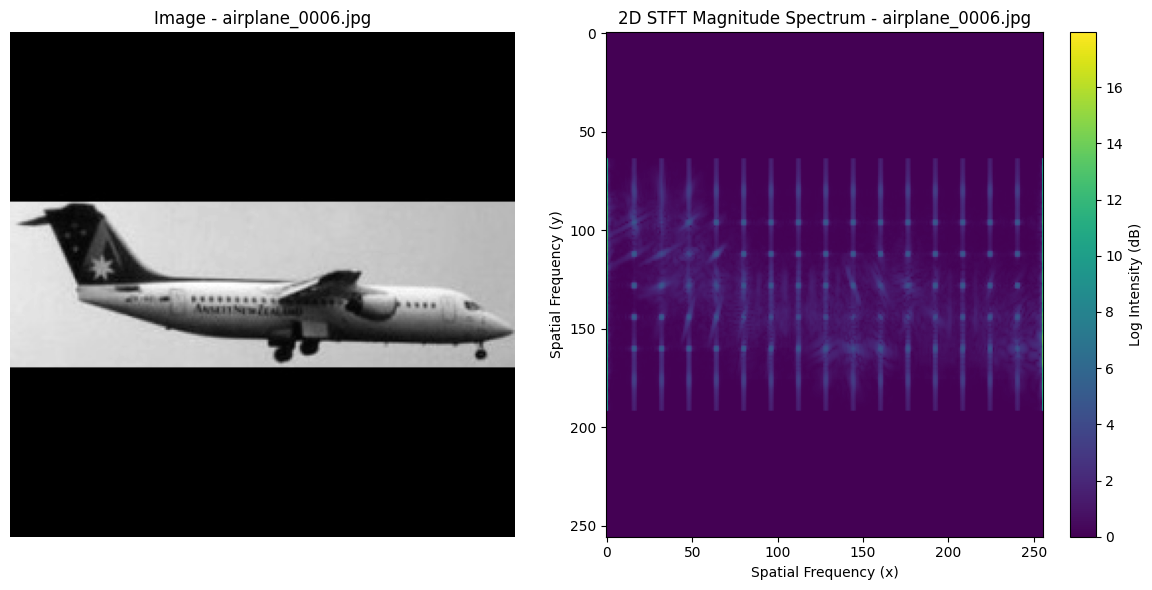

In [7]:
# Example usage
image_path = "./dataset/preprocessed_data/natural_images/airplane/airplane_0006.jpg"  # Replace with one preprocessed image
Sxx = compute_spectrogram(image_path, plot_spect=True)


In [8]:
## different similarity metrics for matching spectrograms

def ssim_metrric(s1, s2):

    s1 = s1 / np.max(s1)
    s2 = s2 / np.max(s2)

    correlation = ssim(s1, s2, data_range=1.0)

    return correlation



def pearson_metric(s1, s2):

    s1 = s1.flatten()
    s2 = s2.flatten()

    correlation = np.corrcoef(s1, s2)[0, 1]

    return correlation




def match_spectrograms(s1, s2):
    """
    Matches two spectrograms using correlation.

    Args:
        spectrogram1 (ndarray): First spectrogram (Sxx from compute_spectrogram).
        spectrogram2 (ndarray): Second spectrogram (Sxx from compute_spectrogram).
    
    Returns:
        float: Correlation coefficient between the two spectrograms.
    """

    correlation = pearson_metric(s1, s2)
    # correlation = ssim_metrric(s1, s2)

    correlation = round(correlation, 3)
    return correlation




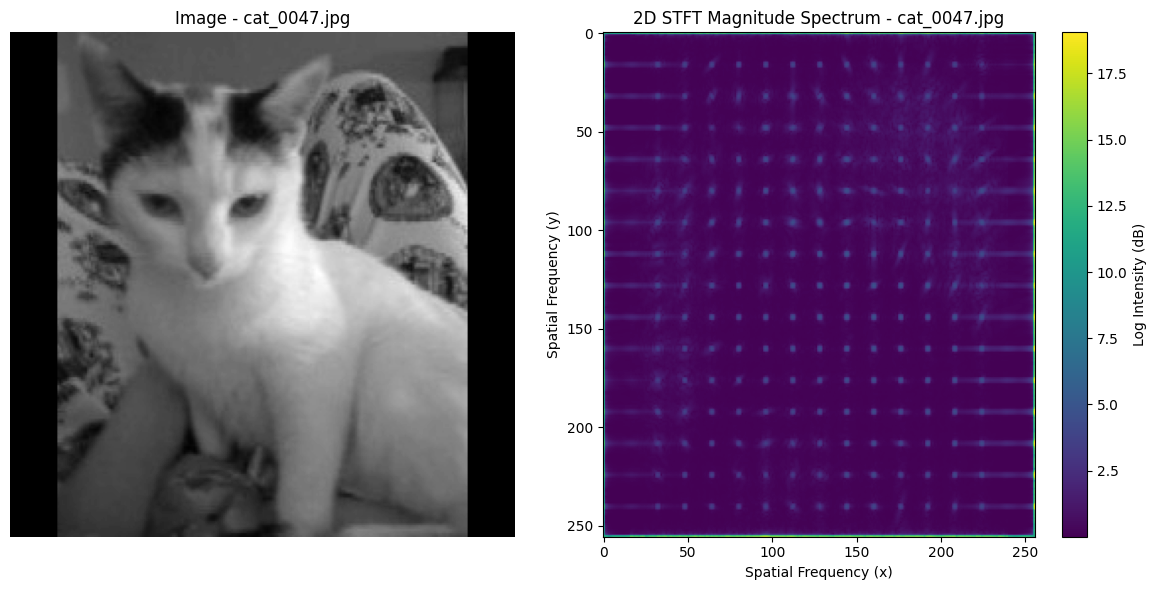

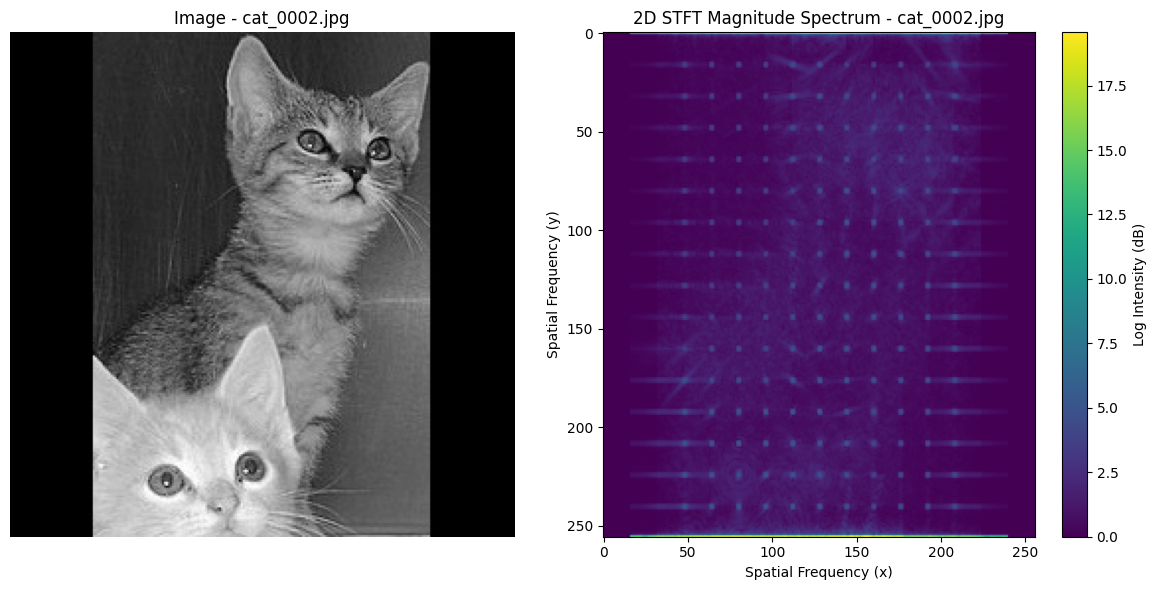

Correlation between the two spectrograms: 0.068


In [9]:
image_path1 = "./dataset/preprocessed_data/natural_images/cat/cat_0047.jpg"
image_path2 = "./dataset/preprocessed_data/natural_images/cat/cat_0002.jpg"

Sxx1 = compute_spectrogram(image_path1, plot_spect=True)
Sxx2 = compute_spectrogram(image_path2, plot_spect=True)


correlation = match_spectrograms(Sxx1, Sxx2)
print(f"Correlation between the two spectrograms: {correlation}")


In [10]:
def batch_spectrogram_matching(target_image_path, dataset_folder, target_size=(256, 256), top_n=5):
    """
    Preprocesses the target image, computes its spectrogram, and finds the corresponding top matches of image specrtograms from the dataset.


    Args:
        target_image_path (str): Target Image path.
        dataset_folder (str): Folder containing preprocessed dataset images.
        target_size (tuple): Target size for preprocessing (default: 256x256).
        top_n (int): Number of best top matches to return (default: 5).

    Returns:
        list of tuples: Top matches with file paths and their correlation scores.
    """
    # Preprocess the target image
    target_image = cv.imread(target_image_path)
    if target_image is None:
        raise ValueError(f"Could not load target image: {target_image_path}")

    preprocessed_target = resize_and_pad(target_image, target_size)
    preprocessed_target_gray = cv.cvtColor(preprocessed_target, cv.COLOR_BGR2GRAY)



    # Compute the spectrogram for the preprocessed target image
    target_spectrogram = compute_spectrogram_image(preprocessed_target_gray)





    # Initialize a list to store results
    results = []

    

    # Iterate through all images in the dataset
    for root, _, files in os.walk(dataset_folder):
        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Full path to the dataset image
                file_path = os.path.join(root, file_name)

                # Compute the spectrogram for the dataset image
                dataset_spectrogram = compute_spectrogram(file_path, plot_spect=False)

                # Align spectrogram dimensions (if necessary)
                min_rows = min(target_spectrogram.shape[0], dataset_spectrogram.shape[0])
                min_cols = min(target_spectrogram.shape[1], dataset_spectrogram.shape[1])
                target_spectrogram_aligned = target_spectrogram[:min_rows, :min_cols]
                dataset_spectrogram_aligned = dataset_spectrogram[:min_rows, :min_cols]

                # Compute the correlation
                correlation = match_spectrograms(target_spectrogram_aligned, dataset_spectrogram_aligned)

                # Append result (file path and correlation score)
                results.append({"file_path":file_path, "correlation":correlation})

        print(f"Processed folder: {root}")

    # Sort results by correlation score (descending order) and return the top N matches
    results = sorted(results, key=lambda x: x["correlation"], reverse=True)
    return results[:top_n]


In [11]:
# Paths
target_image_path = "./dataset/preprocessed_data/natural_images/cat/cat_0047.jpg"  # Replace with the path to your target image
dataset_folder = "./dataset/preprocessed_data/natural_images"  # Replace with the path to your preprocessed dataset folder


# Find the top 5 matches
top_matches = batch_spectrogram_matching(target_image_path, dataset_folder, target_size=(256, 256), top_n=3)


Processed folder: ./dataset/preprocessed_data/natural_images
Processed folder: ./dataset/preprocessed_data/natural_images\airplane
Processed folder: ./dataset/preprocessed_data/natural_images\car
Processed folder: ./dataset/preprocessed_data/natural_images\cat
Processed folder: ./dataset/preprocessed_data/natural_images\dog
Processed folder: ./dataset/preprocessed_data/natural_images\flower
Processed folder: ./dataset/preprocessed_data/natural_images\fruit
Processed folder: ./dataset/preprocessed_data/natural_images\motorbike
Processed folder: ./dataset/preprocessed_data/natural_images\person


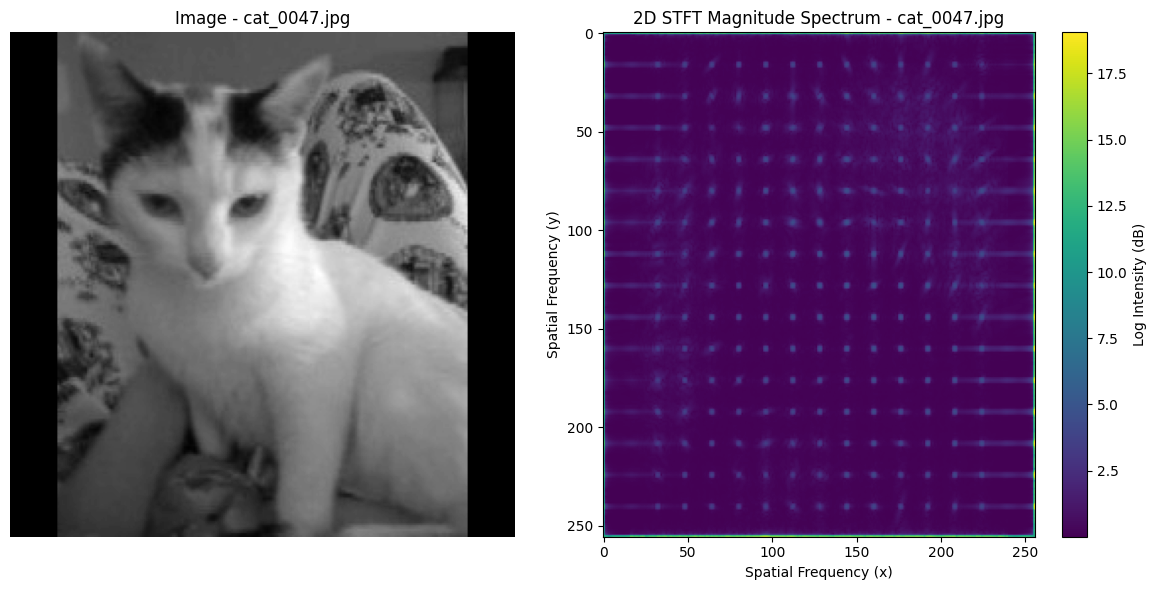

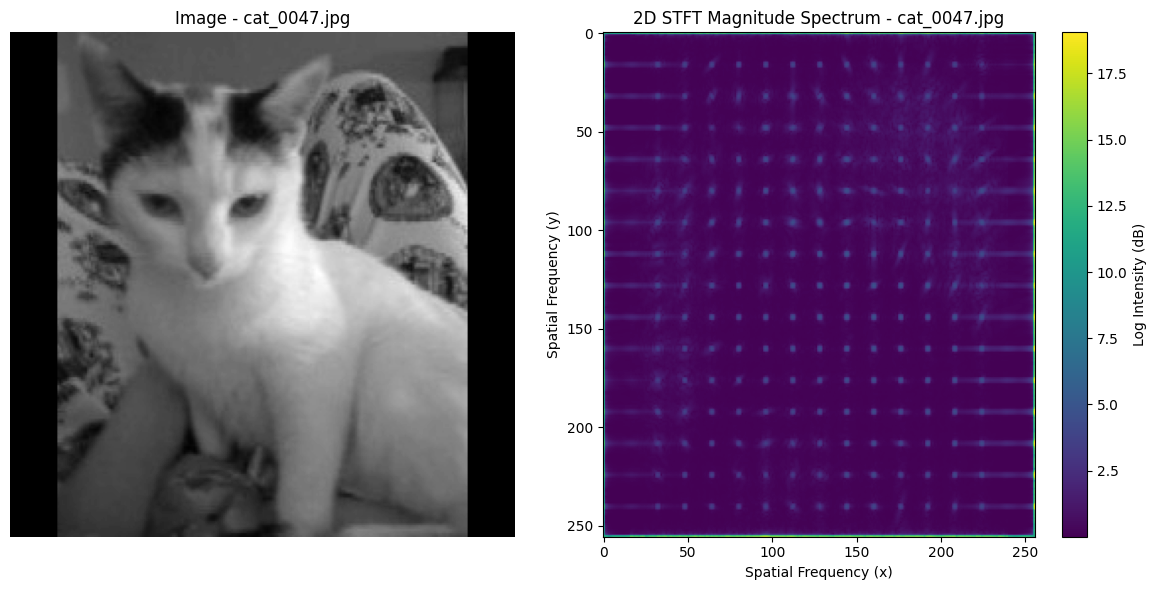

Correlation with ./dataset/preprocessed_data/natural_images\cat\cat_0047.jpg: 1.0


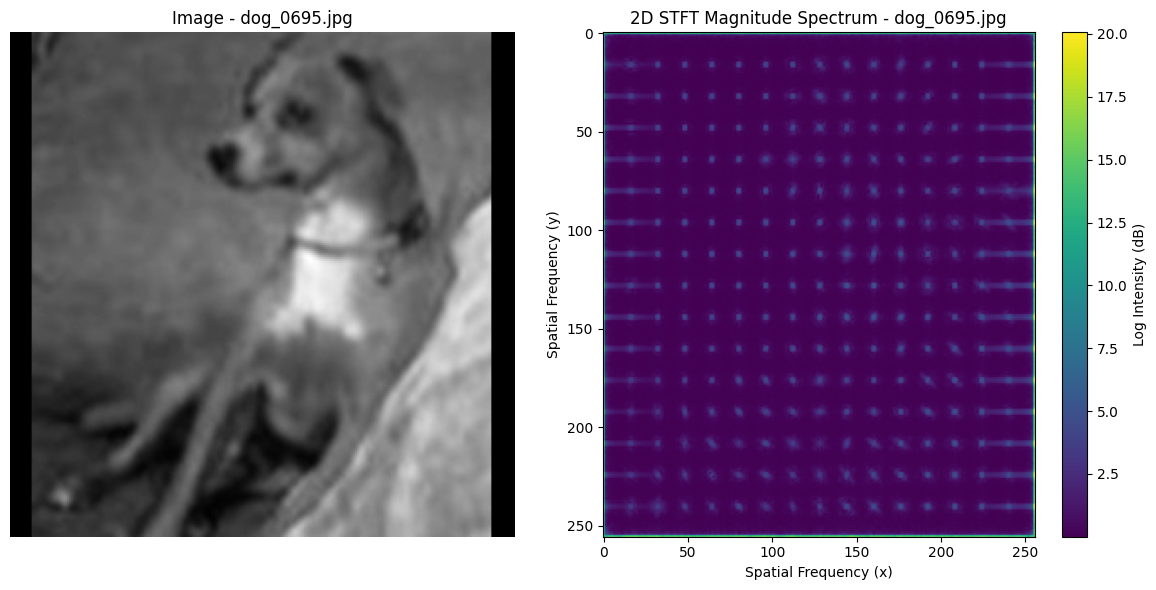

Correlation with ./dataset/preprocessed_data/natural_images\dog\dog_0695.jpg: 0.941


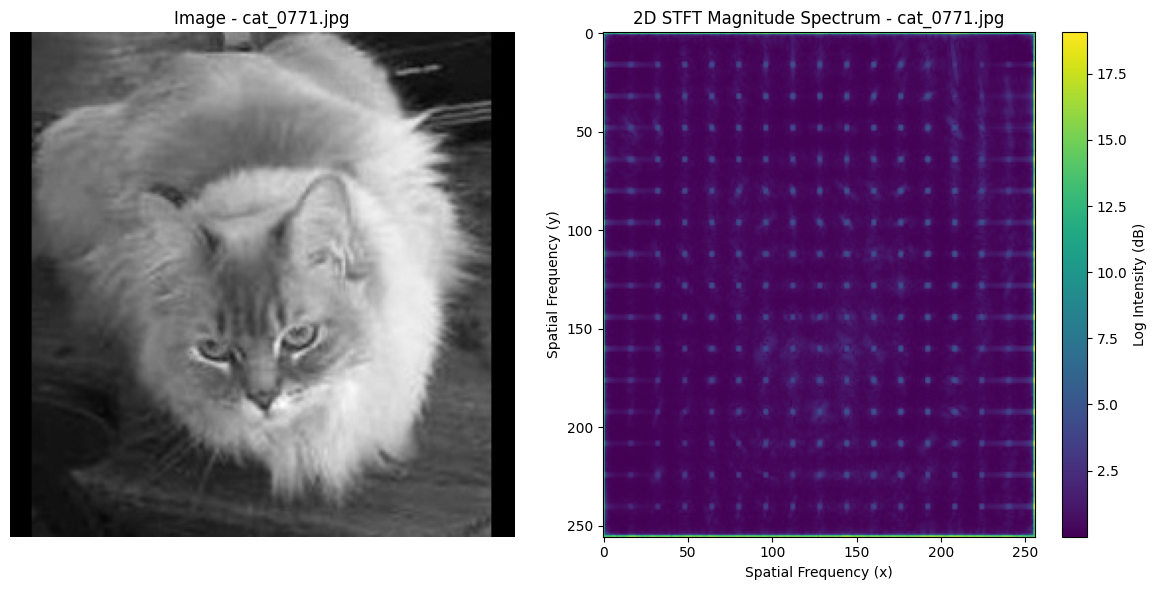

Correlation with ./dataset/preprocessed_data/natural_images\cat\cat_0771.jpg: 0.94


In [12]:
def D(target_image_path,top_matches):
    input_Sxx = compute_spectrogram(target_image_path, plot_spect=True)

    for match in top_matches:
        Sxx = compute_spectrogram(match['file_path'], plot_spect=True)
        correlation = match_spectrograms(input_Sxx, Sxx)
        print(f"Correlation with {match['file_path']}: {correlation}")


D(target_image_path,top_matches)

In [13]:
# Configurations for styles and layout

class StyleConfig:
    PADDING = {
        'small': 5,
        'medium': 10,
        'large': 20
    }
    WINDOW_MIN_SIZE = (800, 600)
    COLORS = {
        'bg': '#f0f0f0',
        'fg': '#333333',
        'white': '#ffffff',
        'accent': '#4a90e2'
    }
    FONTS = {
        'header': ('Helvetica', 24, 'bold'),
        'subheader': ('Helvetica', 12),
        'normal': ('Helvetica', 10),
        'bold': ('Helvetica', 12, 'bold')
    }

class Command:
    def execute(self):
        pass
    
    def undo(self):
        pass



In [14]:
# Commands for handling image selection

class ImageSelectionCommand(Command):
    def __init__(self, gui, old_path, new_path):
        self.gui = gui
        self.old_path = old_path
        self.new_path = new_path
    
    def execute(self):
        self.gui.target_image_path.set(self.new_path)
        self.gui.display_image(self.new_path, self.gui.target_image_label, "Target Image")
    
    def undo(self):
        self.gui.target_image_path.set(self.old_path)
        if self.old_path:
            self.gui.display_image(self.old_path, self.gui.target_image_label, "Target Image")
        else:
            self.gui.target_image_label.configure(image="")

In [15]:
# History tracker for commands

class CommandHistory:
    def __init__(self):
        self.undo_stack = []
        self.redo_stack = []
    
    def execute(self, command):
        command.execute()
        self.undo_stack.append(command)
        self.redo_stack.clear()
    
    def undo(self):
        if self.undo_stack:
            command = self.undo_stack.pop()
            command.undo()
            self.redo_stack.append(command)
    
    def redo(self):
        if self.redo_stack:
            command = self.redo_stack.pop()
            command.execute()
            self.undo_stack.append(command)



In [ ]:
# Main GUI class

class GUI(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Frequency Matching Tool")

        # Variables for the application state
        self.target_image_path = tk.StringVar()
        self.top_matches_var = tk.StringVar(value="3")
        
        # Configure window appearance and behavior
        self.configure(bg=StyleConfig.COLORS['bg'])
        self.geometry("800x600")
        self.minsize(*StyleConfig.WINDOW_MIN_SIZE)
        
        # Set up grid layout
        self.grid_columnconfigure(0, weight=1)
        self.grid_rowconfigure(0, weight=1)
        
        
        # Initialize UI elements and command history
        self.create_widgets()
        self.setup_shortcuts()
        self.history = CommandHistory()

    def create_widgets(self):
        # Scrollable main container for the UI
        self.main_canvas = tk.Canvas(self, bg=StyleConfig.COLORS['bg'])
        self.main_scrollbar = ttk.Scrollbar(self, orient="vertical", command=self.main_canvas.yview)
        self.main_scrollable_frame = tk.Frame(self.main_canvas, bg=StyleConfig.COLORS['bg'])

        # Configure the canvas scroll behavior
        self.main_canvas.configure(yscrollcommand=self.main_scrollbar.set)
        
        # Place the main scrollable elements
        self.main_canvas.grid(row=0, column=0, sticky='nsew')
        self.main_scrollbar.grid(row=0, column=1, sticky='ns')
        
        # Create window in canvas
        self.main_canvas.create_window((0, 0), window=self.main_scrollable_frame, anchor='nw')
        self.main_scrollable_frame.bind("<Configure>",
            lambda e: self.main_canvas.configure(scrollregion=self.main_canvas.bbox("all")))

        # Header
        header_frame = tk.Frame(self.main_scrollable_frame, bg=StyleConfig.COLORS['bg'])
        header_frame.grid(row=0, column=0, columnspan=2, sticky='ew', padx=20, pady=(20,10))
        
        header_label = tk.Label(header_frame, 
                              text="Frequency Matching Tool",
                              font=StyleConfig.FONTS['header'],
                              bg=StyleConfig.COLORS['bg'],
                              fg=StyleConfig.COLORS['fg'])
        header_label.pack()

        # Upper section container (for target and parameters)
        upper_container = tk.Frame(self.main_scrollable_frame, bg=StyleConfig.COLORS['bg'])
        upper_container.grid(row=1, column=0, sticky='ew', padx=20, pady=10)
        upper_container.grid_columnconfigure(0, weight=1)
        upper_container.grid_columnconfigure(1, weight=1)

        # Create target and parameters sections side by side
        self.create_target_section(upper_container)
        self.create_parameters_section(upper_container)
        
        # Results section below
        self.create_results_section(self.main_scrollable_frame)

        # Bind mouse wheel to both canvases
        self.bind_mouse_scroll(self.main_canvas)

    def bind_mouse_scroll(self, widget):
        # Bind mouse wheel on Linux and Windows
        widget.bind("<MouseWheel>", self._on_mousewheel)
        widget.bind("<Button-4>", self._on_mousewheel)
        widget.bind("<Button-5>", self._on_mousewheel)
        
        # Bind for child widgets
        for child in widget.winfo_children():
            self.bind_mouse_scroll(child)

    def _on_mousewheel(self, event):
        # Handle different event types for different platforms
        if event.num == 4:  # Linux scroll up
            delta = -1
        elif event.num == 5:  # Linux scroll down
            delta = 1
        else:  # Windows
            delta = -1 * (event.delta // 120)

        # Scroll the canvas
        if event.widget == self.main_canvas or event.widget.master == self.main_canvas:
            self.main_canvas.yview_scroll(delta, "units")
        elif event.widget == self.canvas or event.widget.master == self.canvas:
            self.canvas.yview_scroll(delta, "units")

    def update_scroll_bindings(self):
        # Rebind scroll events for all widgets
        self.bind_mouse_scroll(self.main_canvas)
        self.bind_mouse_scroll(self.canvas)


    # Create section for selecting and displaying the target image
    def create_target_section(self, parent):
        target_frame = tk.LabelFrame(parent, 
                                   text="Target Image", 
                                   font=StyleConfig.FONTS['subheader'],
                                   bg=StyleConfig.COLORS['white'],
                                   padx=15, pady=15)
        target_frame.grid(row=0, column=0, sticky='nsew', padx=(0,10))
        
        browse_button = ttk.Button(target_frame, 
                                 text="Browse",
                                 command=self.browse_target_image)
        browse_button.pack(anchor='w')
        
        self.target_image_label = tk.Label(target_frame, bg=StyleConfig.COLORS['white'])
        self.target_image_label.pack(pady=10)

    # Create section for parameters
    def create_parameters_section(self, parent):
        params_frame = tk.LabelFrame(parent, 
                                   text="Parameters",
                                   font=StyleConfig.FONTS['subheader'],
                                   bg=StyleConfig.COLORS['white'],
                                   padx=15, pady=15)
        params_frame.grid(row=0, column=1, sticky='nsew', padx=(10,0))
        
        param_content = tk.Frame(params_frame, bg=StyleConfig.COLORS['white'])
        param_content.pack(expand=True, fill='both')
        
        tk.Label(param_content, 
                text="Number of Matches:",
                font=StyleConfig.FONTS['normal'],
                bg=StyleConfig.COLORS['white']).pack(pady=(0,5))
        
        ttk.Entry(param_content, 
                 textvariable=self.top_matches_var,
                 width=8).pack(pady=(0,10))
        
        button_frame = tk.Frame(param_content, bg=StyleConfig.COLORS['white'])
        button_frame.pack(fill='x', pady=(10,0))
        
        ttk.Button(button_frame,
                  text="Run Matching",
                  command=self.run_matching).pack(side='left', padx=5, expand=True)
        
        ttk.Button(button_frame,
                  text="Clear",
                  command=self.clear_interface).pack(side='left', padx=5, expand=True)


    # Create section for displaying results
    def create_results_section(self, parent):
        results_frame = tk.LabelFrame(parent,
                                    text="Results",
                                    font=StyleConfig.FONTS['subheader'],
                                    bg=StyleConfig.COLORS['white'])
        results_frame.grid(row=2, column=0, columnspan=2, sticky='nsew', padx=20, pady=(0,10))
        results_frame.grid_rowconfigure(0, weight=1)
        results_frame.grid_columnconfigure(0, weight=1)

        # Scrollable canvas setup
        self.canvas = tk.Canvas(results_frame, bg=StyleConfig.COLORS['white'], width=600)
        scrollbar = ttk.Scrollbar(results_frame, orient="vertical", 
                                command=self.canvas.yview)
        
        self.scrollable_frame = tk.Frame(self.canvas, bg=StyleConfig.COLORS['white'])
        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw", width=600)
        self.canvas.configure(yscrollcommand=scrollbar.set)
        
        self.canvas.grid(row=0, column=0, sticky='nsew', padx=5, pady=5)
        scrollbar.grid(row=0, column=1, sticky='ns')

        # Add mouse wheel binding
        self.bind_mouse_scroll(self.canvas)

    # Set up keyboard shortcuts
    def setup_shortcuts(self):
        self.bind('<Control-o>', lambda e: self.browse_target_image())
        self.bind('<Control-z>', lambda e: self.history.undo())
        self.bind('<Control-y>', lambda e: self.history.redo())
        self.bind('<Control-r>', lambda e: self.run_matching())
        self.bind('<Escape>', lambda e: self.clear_interface())


    # Browse and select target image
    def browse_target_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[("Image files", "*.png *.jpg *.jpeg")]
        )
        if file_path:
            old_path = self.target_image_path.get()
            command = ImageSelectionCommand(self, old_path, file_path)
            self.history.execute(command)


    # Display an image in a specified label
    def display_image(self, image_path, label, title):
        img = cv.imread(image_path)
        if img is None:
            messagebox.showerror("Error", f"Unable to load image: {image_path}")
            return
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = img.resize((200, 200), Image.Resampling.LANCZOS)
        img_tk = ImageTk.PhotoImage(img)
        label.configure(image=img_tk)
        label.image = img_tk
        label.text = title

    def plot_spectrogram_to_image(self, freqs, times, Sxx, show_axes=True):
        plt.figure(figsize=(4, 4))
        plt.pcolormesh(times, freqs, 10 * np.log10(Sxx), shading='gouraud')
        if show_axes:
            plt.xlabel("Time")
            plt.ylabel("Frequency")
            plt.colorbar(label="Intensity (dB)")
        buffer = BytesIO()
        plt.savefig(buffer, format="png", bbox_inches="tight", pad_inches=0)
        buffer.seek(0)
        plt.close()
        return Image.open(buffer)

    def display_image_and_spectrogram(self, image_path, spectrogram, parent_frame, title, correlation=None):
        display_frame = tk.Frame(parent_frame, 
                               bg=StyleConfig.COLORS['white'],
                               bd=1,
                               relief=tk.RIDGE)
        display_frame.pack(side=tk.TOP, fill=tk.X, pady=5, padx=5)

        # Image display
        img_frame = tk.Frame(display_frame, bg=StyleConfig.COLORS['white'], padx=10, pady=10)
        img_frame.pack(side=tk.LEFT)
        
        if image_path and os.path.exists(image_path):
            img = cv.imread(image_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = Image.fromarray(img)
                img = img.resize((200, 200), Image.Resampling.LANCZOS)
                img_tk = ImageTk.PhotoImage(img)
                img_label = tk.Label(img_frame, 
                                   image=img_tk,
                                   text=f"{title} Image",
                                   compound=tk.BOTTOM,
                                   bg=StyleConfig.COLORS['white'],
                                   font=StyleConfig.FONTS['normal'])
                img_label.image = img_tk
                img_label.pack()

        # Spectrogram display
        spec_frame = tk.Frame(display_frame, bg=StyleConfig.COLORS['white'], padx=10, pady=10)
        spec_frame.pack(side=tk.LEFT)
        
        spectrogram_img = self.plot_spectrogram_to_image(*spectrogram)
        spectrogram_img = spectrogram_img.resize((200, 200), Image.Resampling.LANCZOS)
        spectrogram_tk = ImageTk.PhotoImage(spectrogram_img)
        spec_label = tk.Label(spec_frame,
                            image=spectrogram_tk,
                            text=f"{title} Spectrogram",
                            compound=tk.BOTTOM,
                            bg=StyleConfig.COLORS['white'],
                            font=StyleConfig.FONTS['normal'])
        spec_label.image = spectrogram_tk
        spec_label.pack()

        # Correlation score display
        if correlation is not None:
            score_frame = tk.Frame(display_frame, bg=StyleConfig.COLORS['white'], padx=10, pady=10)
            score_frame.pack(side=tk.LEFT, fill=tk.Y)
            score_label = tk.Label(score_frame,
                                 text=f"Correlation:\n{correlation}",
                                 font=StyleConfig.FONTS['bold'],
                                 bg=StyleConfig.COLORS['white'])
            score_label.pack(expand=True)
    
    # Execute the frequency matching algorithm
    def run_matching(self):
        target_path = self.target_image_path.get()
        if not target_path:
            messagebox.showerror("Error", "Please select a target image.")
            return

        dataset_folder = "./dataset/preprocessed_data/natural_images"
        top_n = int(self.top_matches_var.get())

        try:
            # Clear previous results
            self.update_idletasks()

            for widget in self.scrollable_frame.winfo_children():
                widget.destroy()

            # Matching logic
            top_matches = batch_spectrogram_matching(target_path, dataset_folder, 
                                                   target_size=(256, 256), top_n=top_n)
            target_freqs, target_times, target_Sxx = compute_spectrogram(target_path, 
                                                                       plot_spect=False)
            

            # Display target image and spectrogram
            self.display_image_and_spectrogram(
                target_path, (target_freqs, target_times, target_Sxx), 
                self.scrollable_frame, "Target"
            )

            # Display matches with their spectrograms and correlation scores
            for i, match in enumerate(top_matches):
                freqs, times, Sxx = compute_spectrogram(match['file_path'], plot_spect=False)
                self.display_image_and_spectrogram(
                    match['file_path'], (freqs, times, Sxx), 
                    self.scrollable_frame, f"Match {i+1}", 
                    correlation=match['correlation']
                )

            self.canvas.configure(scrollregion=self.canvas.bbox("all"))

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")


    # Clear the interface, resetting the application state
    def clear_interface(self):
        self.target_image_path.set("")
        self.target_image_label.configure(image="")
        for widget in self.scrollable_frame.winfo_children():
            widget.destroy()


In [16]:
class GUI(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Frequency Matching Tool")

        # Variables for the application state
        self.target_image_path = tk.StringVar()
        self.top_matches_var = tk.StringVar(value="3")
        
        # Configure window appearance and behavior
        self.configure(bg="lightgray")
        self.geometry("800x600")
        
        # Set up grid layout
        self.grid_columnconfigure(0, weight=1)
        self.grid_rowconfigure(0, weight=1)
        
        # Initialize UI elements
        self.create_widgets()

    def create_widgets(self):
        # Scrollable main container for the UI
        self.main_canvas = tk.Canvas(self, bg="lightgray")
        self.main_scrollbar = ttk.Scrollbar(self, orient="vertical", command=self.main_canvas.yview)
        self.main_scrollable_frame = tk.Frame(self.main_canvas, bg="lightgray")

        # Configure the canvas scroll behavior
        self.main_canvas.configure(yscrollcommand=self.main_scrollbar.set)
        
        # Place the main scrollable elements
        self.main_canvas.grid(row=0, column=0, sticky='nsew')
        self.main_scrollbar.grid(row=0, column=1, sticky='ns')
        
        # Create window in canvas
        self.main_canvas.create_window((0, 0), window=self.main_scrollable_frame, anchor='nw')
        self.main_scrollable_frame.bind("<Configure>",
            lambda e: self.main_canvas.configure(scrollregion=self.main_canvas.bbox("all")))

        # Header
        header_frame = tk.Frame(self.main_scrollable_frame, bg="lightgray")
        header_frame.grid(row=0, column=0, columnspan=2, sticky='ew', padx=20, pady=(20,10))
        
        header_label = tk.Label(header_frame, 
                              text="Frequency Matching Tool",
                              font=("Helvetica", 18, "bold"),
                              bg="lightgray",
                              fg="black")
        header_label.pack()

        # Upper section container (for target and parameters)
        upper_container = tk.Frame(self.main_scrollable_frame, bg="lightgray")
        upper_container.grid(row=1, column=0, sticky='ew', padx=20, pady=10)
        upper_container.grid_columnconfigure(0, weight=1)
        upper_container.grid_columnconfigure(1, weight=1)

        # Create target and parameters sections side by side
        self.create_target_section(upper_container)
        self.create_parameters_section(upper_container)
        
        # Results section below
        self.create_results_section(self.main_scrollable_frame)

    # Create section for selecting and displaying the target image
    def create_target_section(self, parent):
        target_frame = tk.LabelFrame(parent, text="Target Image", font=("Helvetica", 12, "bold"), bg="white", padx=15, pady=15)
        target_frame.grid(row=0, column=0, sticky='nsew', padx=(0,10))
        
        browse_button = ttk.Button(target_frame, text="Browse", command=self.browse_target_image)
        browse_button.pack(anchor='w')
        
        self.target_image_label = tk.Label(target_frame, bg="white")
        self.target_image_label.pack(pady=10)

    # Create section for parameters
    def create_parameters_section(self, parent):
        params_frame = tk.LabelFrame(parent, text="Parameters", font=("Helvetica", 12, "bold"), bg="white", padx=15, pady=15)
        params_frame.grid(row=0, column=1, sticky='nsew', padx=(10,0))
        
        param_content = tk.Frame(params_frame, bg="white")
        param_content.pack(expand=True, fill='both')
        
        tk.Label(param_content, text="Number of Matches:", font=("Helvetica", 10), bg="white").pack(pady=(0,5))
        
        ttk.Entry(param_content, textvariable=self.top_matches_var, width=8).pack(pady=(0,10))
        
        button_frame = tk.Frame(param_content, bg="white")
        button_frame.pack(fill='x', pady=(10,0))
        
        ttk.Button(button_frame, text="Run Matching", command=self.run_matching).pack(side='left', padx=5, expand=True)
        ttk.Button(button_frame, text="Clear", command=self.clear_interface).pack(side='left', padx=5, expand=True)

    # Create section for displaying results
    def create_results_section(self, parent):
        results_frame = tk.LabelFrame(parent, text="Results", font=("Helvetica", 12, "bold"), bg="white")
        results_frame.grid(row=2, column=0, columnspan=2, sticky='nsew', padx=20, pady=(0,10))
        results_frame.grid_rowconfigure(0, weight=1)
        results_frame.grid_columnconfigure(0, weight=1)

        # Scrollable canvas setup
        self.canvas = tk.Canvas(results_frame, bg="white", width=600)
        scrollbar = ttk.Scrollbar(results_frame, orient="vertical", command=self.canvas.yview)
        
        self.scrollable_frame = tk.Frame(self.canvas, bg="white")
        self.scrollable_frame.bind(
            "<Configure>",
            lambda e: self.canvas.configure(scrollregion=self.canvas.bbox("all"))
        )

        self.canvas.create_window((0, 0), window=self.scrollable_frame, anchor="nw", width=600)
        self.canvas.configure(yscrollcommand=scrollbar.set)
        
        self.canvas.grid(row=0, column=0, sticky='nsew', padx=5, pady=5)
        scrollbar.grid(row=0, column=1, sticky='ns')

    # Browse and select target image
    def browse_target_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg")])
        if file_path:
            self.target_image_path.set(file_path)
            self.display_image(file_path, self.target_image_label, "Target Image")

    # Display an image in a specified label
    def display_image(self, image_path, label, title):
        img = cv.imread(image_path)
        if img is None:
            messagebox.showerror("Error", f"Unable to load image: {image_path}")
            return
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        img = img.resize((200, 200), Image.Resampling.LANCZOS)
        img_tk = ImageTk.PhotoImage(img)
        label.configure(image=img_tk)
        label.image = img_tk
        label.text = title

    def plot_spectrogram_to_image(self, Sxx, show_axes=True):
        plt.figure(figsize=(4, 4))
        plt.imshow(np.log(1 + Sxx), cmap='viridis', aspect='auto')
        if show_axes:
            plt.colorbar(label="Log Intensity")
        buffer = BytesIO()
        plt.savefig(buffer, format="png", bbox_inches="tight", pad_inches=0)
        buffer.seek(0)
        plt.close()
        return Image.open(buffer)

    def display_image_and_spectrogram(self, image_path, spectrogram, parent_frame, title, correlation=None):
        display_frame = tk.Frame(parent_frame, bg="white", bd=1, relief=tk.RIDGE)
        display_frame.pack(side=tk.TOP, fill=tk.X, pady=5, padx=5)

        # Image display
        img_frame = tk.Frame(display_frame, bg="white", padx=10, pady=10)
        img_frame.pack(side=tk.LEFT)
        
        if image_path and os.path.exists(image_path):
            img = cv.imread(image_path)
            if img is not None:
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = Image.fromarray(img)
                img = img.resize((200, 200), Image.Resampling.LANCZOS)
                img_tk = ImageTk.PhotoImage(img)
                img_label = tk.Label(img_frame, image=img_tk, text=f"{title} Image", compound=tk.BOTTOM, bg="white", font=("Helvetica", 10))
                img_label.image = img_tk
                img_label.pack()

        # Spectrogram display
        spec_frame = tk.Frame(display_frame, bg="white", padx=10, pady=10)
        spec_frame.pack(side=tk.LEFT)
        
        spectrogram_img = self.plot_spectrogram_to_image(spectrogram)
        spectrogram_img = spectrogram_img.resize((200, 200), Image.Resampling.LANCZOS)
        spectrogram_tk = ImageTk.PhotoImage(spectrogram_img)
        spec_label = tk.Label(spec_frame, image=spectrogram_tk, text=f"{title} Spectrogram", compound=tk.BOTTOM, bg="white", font=("Helvetica", 10))
        spec_label.image = spectrogram_tk
        spec_label.pack()

        # Correlation score display
        if correlation is not None:
            score_frame = tk.Frame(display_frame, bg="white", padx=10, pady=10)
            score_frame.pack(side=tk.LEFT, fill=tk.Y)
            score_label = tk.Label(score_frame, text=f"Correlation:\n{correlation}", font=("Helvetica", 12, "bold"), bg="white")
            score_label.pack(expand=True)
    
    # Execute the frequency matching algorithm
    def run_matching(self):
        target_path = self.target_image_path.get()
        if not target_path:
            messagebox.showerror("Error", "Please select a target image.")
            return

        dataset_folder = "./dataset/preprocessed_data/natural_images"
        top_n = int(self.top_matches_var.get())

        try:
            # Clear previous results
            for widget in self.scrollable_frame.winfo_children():
                widget.destroy()

            # Matching logic
            top_matches = batch_spectrogram_matching(target_path, dataset_folder, target_size=(256, 256), top_n=top_n)
            target_Sxx = compute_spectrogram(target_path, plot_spect=False)
            
            # Display target image and spectrogram
            self.display_image_and_spectrogram(target_path, target_Sxx, self.scrollable_frame, "Target")

            # Display matches with their spectrograms and correlation scores
            for i, match in enumerate(top_matches):
                Sxx = compute_spectrogram(match['file_path'], plot_spect=False)
                self.display_image_and_spectrogram(match['file_path'], Sxx, self.scrollable_frame, f"Match {i+1}", correlation=match['correlation'])

            self.canvas.configure(scrollregion=self.canvas.bbox("all"))

        except Exception as e:
            messagebox.showerror("Error", f"An error occurred: {e}")


    # Clear the interface, resetting the application state
    def clear_interface(self):
        self.target_image_path.set("")
        self.target_image_label.configure(image="")
        for widget in self.scrollable_frame.winfo_children():
            widget.destroy()


In [17]:
# Create and run the application
app = GUI()
app.mainloop()

Processed folder: ./dataset/preprocessed_data/natural_images
Processed folder: ./dataset/preprocessed_data/natural_images\airplane
Processed folder: ./dataset/preprocessed_data/natural_images\car
Processed folder: ./dataset/preprocessed_data/natural_images\cat
Processed folder: ./dataset/preprocessed_data/natural_images\dog
Processed folder: ./dataset/preprocessed_data/natural_images\flower
Processed folder: ./dataset/preprocessed_data/natural_images\fruit
Processed folder: ./dataset/preprocessed_data/natural_images\motorbike
Processed folder: ./dataset/preprocessed_data/natural_images\person


KeyboardInterrupt: 

In [ ]:
import tkinter as tk
from tkinter import filedialog
import os
import cv2 as cv
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets


# Function to resize and pad an image
def resize_and_pad(image, target_size=(256, 256)):
    h, w = image.shape[:2]
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv.resize(image, (new_w, new_h), interpolation=cv.INTER_AREA)

    delta_w, delta_h = target_w - new_w, target_h - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    return cv.copyMakeBorder(resized, top, bottom, left, right, cv.BORDER_CONSTANT, value=[0, 0, 0])


# Function to preprocess images in a folder
def preprocess_images(input_folder, output_folder, size):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        relative_path = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, relative_path)

        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)

        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file_name)
                img = cv.imread(file_path)

                if img is None:
                    print(f"Error loading image: {file_path}")
                    continue

                resized = resize_and_pad(img, target_size=size)
                gray = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
                output_path = os.path.join(output_subfolder, file_name)
                cv.imwrite(output_path, gray)
                print(f"Processed: {file_path} -> {output_path}")


# Function to process and display a single image
def process_and_display_image(file_path):
    image = cv.imread(file_path)
    resized = resize_and_pad(image, target_size=(256, 256))
    gray_image = cv.cvtColor(resized, cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray_image, 100, 200)

    # Display the original and processed images
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(gray_image, cmap="gray")
    ax[1].set_title("Grayscale Image")
    ax[1].axis("off")

    ax[2].imshow(edges, cmap="gray")
    ax[2].set_title("Edge-Detected Image")
    ax[2].axis("off")

    plt.show()


# Function to select a dataset folder
def select_dataset_folder(_):
    root = tk.Tk()
    root.withdraw()
    folder_path = filedialog.askdirectory()

    if folder_path:
        file_label.value = f"Selected Dataset Folder: {folder_path}"
        output_folder = os.path.join(folder_path, "preprocessed_data")
        preprocess_images(folder_path, output_folder, size=(256, 256))
        file_label.value = f"Processed images saved to: {output_folder}"
    else:
        file_label.value = "No folder selected."


# Function to select a single image
def select_single_image(_):
    root = tk.Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png;*.bmp")])

    if file_path:
        file_label.value = f"Selected File: {file_path}"
        process_and_display_image(file_path)
    else:
        file_label.value = "No file selected."


# Widgets for GUI
file_label = widgets.Label(value="No folder or file selected.")
dataset_button = widgets.Button(description="Select Dataset Folder")
image_button = widgets.Button(description="Select Image")

# Event bindings
dataset_button.on_click(select_dataset_folder)
image_button.on_click(select_single_image)

# Display widgets
display(file_label, dataset_button, image_button)
